In [58]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [60]:
df = pd.read_csv(r"C:\Users\Ayakhaled\Downloads\IMDB Dataset.csv\IMDB Dataset.csv")

In [62]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [64]:
df = df.drop_duplicates()

In [66]:
df["review"] = df["review"].apply(lambda x: re.sub(r'<.*?>', '', x)) 
df["review"] = df["review"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower().strip())  
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})


In [68]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am a catholic taught in parochial elementary...,0
49998,im going to have to disagree with the previous...,0


In [70]:
def preprocess_text(df, max_words=10000, max_len=200):
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(df["review"])
    sequences = tokenizer.texts_to_sequences(df["review"])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded_sequences, df["sentiment"].values, tokenizer


In [72]:
def build_rnn_model(max_words=10000, max_len=200):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [74]:
X, y, tokenizer = preprocess_text(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
model = build_rnn_model()
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 74s 111ms/step - accuracy: 0.6796 - loss: 0.5680 - val_accuracy: 0.8514 - val_loss: 0.3601
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.8821 - loss: 0.2936 - val_accuracy: 0.8363 - val_loss: 0.3583
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 80s 118ms/step - accuracy: 0.9122 - loss: 0.2291 - val_accuracy: 0.8715 - val_loss: 0.3260
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.9376 - loss: 0.1711 - val_accuracy: 0.8670 - val_loss: 0.3707
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 82s 121ms/step - accuracy: 0.9564 - loss: 0.1240 - val_accuracy: 0.8685 - val_loss: 0.4062


In [77]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step


In [78]:
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8685
Confusion Matrix:
 [[4378  561]
 [ 743 4235]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      4939
           1       0.88      0.85      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



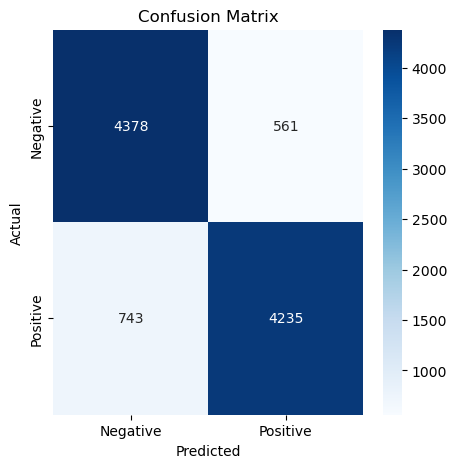

In [79]:
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()